**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp

     |████████████████████████████████| 11.0 MB 33.5 MB/s 
     |████████████████████████████████| 743 kB 54.6 MB/s 


In [2]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 32.1 MB/s 


In [3]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=db44e529a389ca69f57a37d678f9db65b0d4816e2cef68f5933340a5b63d39f2
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=7d7066d440d59bfd33bd82f6eb25d585617f0ff1b35f35de3a664c46559b0e7a
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [4]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [14]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [16]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [18]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [19]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [20]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

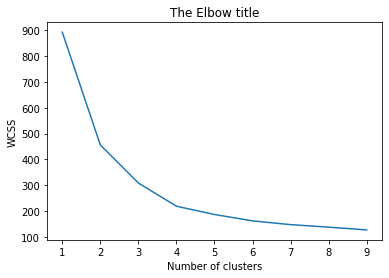

In [74]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [110]:
#run kmeans with no. of clusters you see fit the most

k = 6

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [111]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [112]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...
3,3,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
4,4,5 เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญ เลยก็...
5,5,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [113]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [114]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [116]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [117]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [118]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [119]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [141]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'ที่', 'อัน', 'นี้', 'นะ', 'คะ', 'ค่ะ', 'ดิชั้น', 'ซอย', 'ม๊าก', 'กิ่วๆ', 'นิวคุง', 'ดิส์ส์ส์','tamp', 'ดิ', 'ชั้น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "บูลเบอร์รี่โซดา", "สตอเบอร์รี่โซดา", "กีวีโซดา", "บูลฮาวาย", "เค้กนมสด", "เค้กชาไทย", "เค้กนมเย็น", " ชิบูยะ ฮันนี่ โทสท์", "ไอติมวนิลา", "ยำทิวทัศน์", "ชาเสาวรส", "ชาเขียว", "อาหารไทย", "อาหารอีสาน"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [142]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [143]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 8), (ผม, 5), (ร้านอาหาร, 5), (ทาน, 4), ..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 13), (กาแฟ, 11), (ทาน, 6), (น, 4),..."
2,2,โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่...,"[โลตัส, พัฒนาการ, ชี, ท, เค้ก, หม่ำ, นึง, ค่, ...","[(ร้านกาแฟ, 10), (กาแฟ, 6), (เบเกอรี่, 4), (พา..."
3,3,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 8), (กก, 7), (อร่อย, 6), (ทาน, 5)..."
4,4,เป็นร้านที่สะดุดตาที่สุดบนถนนจรัญเลยก็ว่าได้สถ...,"[สะดุดตา, ถนน, จรัญ, สถาน, ที่ตั้ง, ปากซอย, สุ...","[(ทาน, 7), (กิน, 6), (ร้านกาแฟ, 5), (ชอบ, 5), ..."
5,5,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 5), (..."


In [144]:
df_kmeans['texts_count'].value_counts()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[(ร้านกาแฟ, 10), (กาแฟ, 6), (เบเกอรี่, 4), (พาย, 4), (เค้ก, 3), (คาเฟ่, 3), (แนว, 3), (ชอบ, 3), (ท, 2), (ทาน, 2), (กา, 2), (จ, 2), (ริ, 2), (น่ารัก, 2), (กิน, 2), (ชิล, 2), (เจอ, 2), (บรรยากาศ, 2), (คลาสสิค, 2), (เด่น, 2), (ตกแต่ง, 2), (ร่ำ, 2), (ตั้งอยู่, 2), (รี่, 2), (โลตัส, 1), (พัฒนาการ, 1), (ชี, 1), (หม่ำ, 1), (นึง, 1), (ค่, 1), (โฮมเมด, 1), (อร่อย, 1), (ส, 1), (ไส, 1), (ต์, 1), (-cake, 1), (แอนด์, 1), (บุฟเฟต์, 1), (เสาร์, 1), (อา, 1), (ทิต, 1), (เข้าไป, 1), (บรรยาย, 1), (ศ, 1), (แาน, 1), (สา, 1), (ขาย, 1), (Aprilstore, 1), (บริเวณ, 1), (สวน, 1), (ยู, 1), (เซ็นเตอร์, 1), (หลากหลาย, 1), (รสชาติ, 1), (อากาศ, 1), (ร้อน, 1), (ไปหา, 1), (นั่งเล่น, 1), (รู้จัก, 1), (อ้อ, 1), (พอได้, 1), (ถึงบางอ้อ, 1), (กัร้าน, 1), (สีชมพู, 1), (หวาน, 1), (แหวว, 1), (สะดุดตา, 1), (สยามพารากอน, 1), (ArtofCoffee, 1), (ถูกใจ, 1), (คน, 1), (เครป, 1), (พัน, 1), (!, 1), (ไปมา, 1), (รีวิว, 1), (จัร้าน, 1), (อาหาร, 1), (นั่ง, 1), (อี, 1), (กร้าน, 1), (ตัร้าน, 1), (แผน, 1), (ร, 1), (สิงห์, 1), (วัง, 1), (พญาไท

In [145]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('กิน', 8), ('ผม', 5), ('ร้านอาหาร', 5), ('ทาน', 4), ('ส้มตำ', 4), ('อร่อย', 4), ('รีวิว', 4), ('บ้าน', 3), ('ถนน', 3), ('เมนู', 3)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 13), ('กาแฟ', 11), ('ทาน', 6), ('น', 4), ('นั่ง', 4), ('ดี', 4), ('คน', 3), ('ชอบ', 3), ('นึง', 3), ('เด', 3)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 10), ('กาแฟ', 6), ('เบเกอรี่', 4), ('พาย', 4), ('เค้ก', 3), ('คาเฟ่', 3), ('แนว', 3), ('ชอบ', 3), ('ท', 2), ('ทาน', 2)]

Cluster ID : 3

Most common words include : [('ร้านอาหาร', 8), ('กก', 7), ('อร่อย', 6), ('ทาน', 5), ('ราคา', 4), ('แซ่บ', 4), ('กิน', 4), ('อาหาร', 4), ('รสชาติ', 4), ('สวัสดี', 3)]

Cluster ID : 4

Most common words include : [('ทาน', 7), ('กิน', 6), ('ร้านกาแฟ', 5), ('ชอบ', 5), ('อร่อย', 5), ('กาแฟ', 5), ('ซื้อ', 4), ('หา', 4), ('อาหาร', 3), ('ผม', 3)]

Cluster ID : 5

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 5), ('เครื่องดื่ม', 4

**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [146]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [147]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [148]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [149]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('ราคา', 273), ('(', 270)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1), ('อาหาร', 1), ('เวลา', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('เท', 2), ('แก้', 2), ("['", 1), ('เรื่อง', 1), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1), ('review', 1)]

Cluster ID : 4

Most common words include : [("['", 1), ('สถาน', 1), ('ที่ตั้ง', 1), ('ปากซอย', 1), ('สุขุมวิท', 1), ('บริเวณ', 1), ('ซ้ายมือ', 1), ('ที่นั่ง', 1), ('นั่ง', 1), ('คนอื่น', 1)]

Cluster ID : 5

Most common words include : [('ปัง', 4), ('ภูเขาไฟ', 3), ('ๆๆๆ', 2

**Step 4 - result discussion**

Cluster 0 : ร้านกาแฟที่รวชาติดี คำชมเยอะ


Cluster 1 : พูดถึงแตงโม และน้ำปั่นเป็นส่วนใหญ่ ทำนายว่าเป็นร้านขายน้ำปั่น

Cluster 2 : ร้านที่อาหารไม่อร่อย

Cluster 3 : ร้านขนม นมเนย

Cluster 4 : ร้านอาหารที่มีสถานที่ตั้งบริเวณถนนสุขุมวิท

Cluster 5 : ร้านของหวาน ปังเย็นภูเขาไฟ
